In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(42)
n_samples = 3000
order = 4  # M=4 (5 coeficientes)

# Gerando Entrada Altamente Correlacionada (Filtro AR)
# Entradas correlacionadas tornam o LMS comum muito lento.
b_ar, a_ar = [1], [1, -1.5, 0.9]
x_white = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)
x = signal.lfilter(b_ar, a_ar, x_white)
x /= np.std(x)  # Normalização

# Sistema Desconhecido (Planta)
w_true = np.array([0.5 + 0.1j, -0.3 + 0.4j, 0.1 - 0.2j, 0.4 + 0.3j, -0.1 + 0.1j])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.05 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO LMS-NEWTON ---
# P0: Inicialização da inversa da matriz de correlação (geralmente delta * I)
delta = 0.1
P0 = np.eye(order + 1, dtype=complex) * delta

# alpha: Fator de esquecimento (próximo de 0 para atualização rápida da matriz)
# step: Passo de adaptação mu
filt_newton = pdf.LMSNewton(
    filter_order=order,
    alpha=0.01,
    initial_inv_rx=P0,
    step=0.05
)

result = filt_newton.optimize(x, d, verbose=True)

[LMSNewton] Completed in 26.639 ms


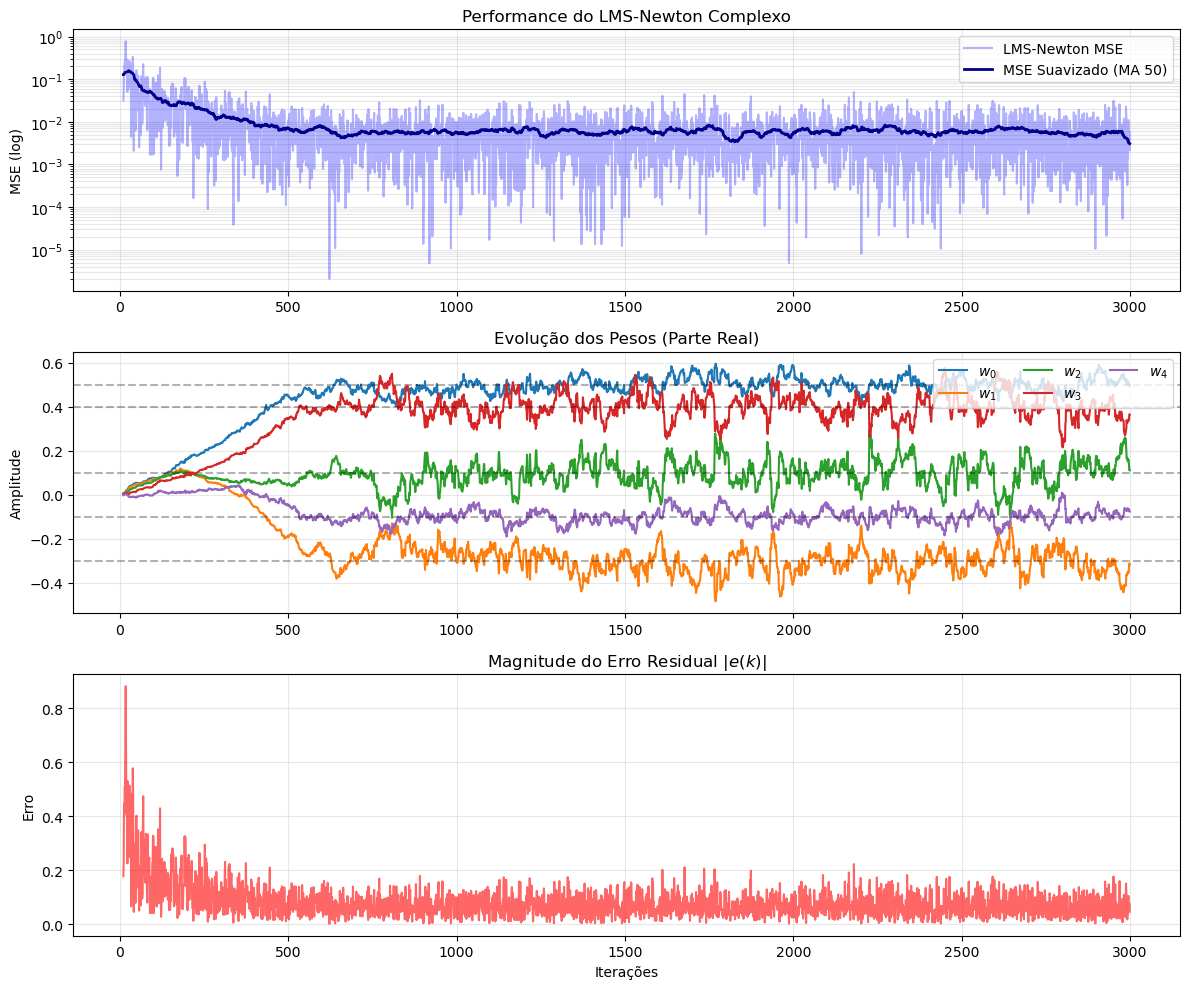

MSE Final: 5.658514e-03


In [3]:
# --- 3. ANÁLISE VISUAL (Corrigida) ---
offset = 10
mse = result.mse()
# Ajustamos os coeficientes para ignorar o estado inicial registrado no construtor
# result.coefficients costuma vir com (N_samples + 1, N_taps)
coeffs_history = result.coefficients

# Sincronizando as dimensões: pegamos apenas as amostras de 0 a N_samples
if coeffs_history.shape[0] > len(mse):
    coeffs_history = coeffs_history[1:] # Remove o w_init para alinhar com os sinais

t = np.arange(len(mse))

plt.figure(figsize=(12, 10))

# Subplot 1: MSE
plt.subplot(3, 1, 1)
plt.semilogy(t[offset:], mse[offset:], label='LMS-Newton MSE', alpha=0.3, color='blue')
# Média móvel com 'same' para manter dimensão
mse_smooth = np.convolve(mse, np.ones(50)/50, mode='same')
plt.semilogy(t[offset:], mse_smooth[offset:], label='MSE Suavizado (MA 50)', color='darkblue', lw=2)
plt.title('Performance do LMS-Newton Complexo')
plt.ylabel('MSE (log)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Evolução dos Pesos (Onde o erro ocorria)
plt.subplot(3, 1, 2)
# Agora t[offset:] e coeffs_history[offset:] possuem o mesmo tamanho
coeffs_real = np.real(coeffs_history)
for i in range(coeffs_real.shape[1]):
    plt.plot(t[offset:], coeffs_real[offset:, i], label=f'$w_{i}$')
    plt.axhline(y=np.real(w_true[i]), color='black', linestyle='--', alpha=0.3)
plt.title('Evolução dos Pesos (Parte Real)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', ncol=3)
plt.grid(True, alpha=0.3)

# Subplot 3: Magnitude do Erro
plt.subplot(3, 1, 3)
plt.plot(t[offset:], np.abs(result.errors[offset:]), color='red', alpha=0.6)
plt.title('Magnitude do Erro Residual $|e(k)|$')
plt.xlabel('Iterações')
plt.ylabel('Erro')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"MSE Final: {np.mean(mse[-100:]):.6e}")